In [1]:
import pandas as pd
import yaml

In [2]:
try:
    with open("./../config.yaml", 'r') as file:
        config = yaml.safe_load(file)
except Exception as e:
    print('Error reading the config file')

In [3]:
data = pd.read_csv(config["data"]["undata_clean"])

## Harmonizing transaction values
Transactions are at a level of detail that is not helpful for this exploratory analysis. Transactions will be be grouped.

In [4]:
data.commodity_transaction.unique()

array(['Electricity - Gross production',
       'From combustible fuels – Main activity',
       'From combustible fuels – Main activity – CHP plants',
       'From combustible fuels – Main activity – Electricity plants',
       'Geothermal – Main activity',
       'Geothermal – Main activity – Electricity plants',
       'Hydro – Main activity', 'Nuclear – Main activity',
       'Nuclear – Main activity – Electricity plants',
       'From other sources – Main activity',
       'From other sources – Main activity – CHP plants',
       'From other sources – Main activity – Electricity plants',
       'Of which: Pumped hydro – Main activity', 'Solar – Main activity',
       'Solar photovoltaic – Main activity', 'Wind – Main activity',
       'From combustible fuels – Autoproducer',
       'From combustible fuels – Autoproducer – CHP plants',
       'From combustible fuels – Autoproducer – Electricity plants',
       'Hydro – Autoproducer', 'From other sources – Autoproducer',
       'Fro

In [5]:
data['transaction_groups']=(data['commodity_transaction']
                            .apply(lambda x: x.replace('Electricity - ', ''))
                            .str.split(' – ').apply(lambda x: x[0])
                            .apply(lambda x: x.lower())
                            .apply(lambda x: 'solar' if 'photovoltaic' in x else x)
                            )


In [6]:
for t in sorted(data.transaction_groups.unique()):
    print(t)

consumption by chemical and petrochemical
consumption by commercial and public services
consumption by construction
consumption by food and tobacco
consumption by households
consumption by iron and steel
consumption by machinery
consumption by manufacturing, construction and non-fuel industry
consumption by mining and quarrying
consumption by non-ferrous metals
consumption by non-metallic minerals
consumption by other
consumption by other manuf., const. and non-fuel ind.
consumption by paper, pulp and print
consumption by rail
consumption by road
consumption by textile and leather
consumption by transport
consumption by transport equipment
consumption by wood and wood products
consumption in agriculture, forestry and fishing
consumption not elsewhere specified (industry)
energy industries own use
exports
final energy consumption
from combustible fuels
from other sources
geothermal
gross demand
gross production
hydro
imports
losses
net production
nuclear
of which: fishing
of which: pump

## Re-calculating totals
There are rows with the same year and same transaction group, these need to be summed to have just one value per year.

In [33]:
def group_totals(df:pd.DataFrame)->pd.DataFrame:
    df_temp = df.copy()

    #select columns
    df_temp = df_temp[['year', 'transaction_groups', 'quantity_GWh']]

    #get sums for years with duplicate transaction groups
    df_temp = df_temp.groupby(['year','transaction_groups'])['quantity_GWh'].sum().reset_index(name='quantity_GWh')


    return df_temp

In [34]:
data_shaped = group_totals(data)

In [35]:
data_shaped.head()

,year,transaction_groups,quantity_GWh
0,2017,consumption by chemical and petrochemical,54219.0
1,2017,consumption by commercial and public services,141479.0
2,2017,consumption by construction,4136.0
3,2017,consumption by food and tobacco,18639.0
4,2017,consumption by households,128200.0


In [36]:
#any missing values?
data_shaped.isnull().sum()

year                  0
transaction_groups    0
quantity_GWh          0
dtype: int64

In [39]:
data_shaped = data_shaped[~data_shaped['transaction_groups'].isin(['of which: fishing', 'of which: pumped hydro'])]

In [42]:
data_shaped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 184 entries, 0 to 190
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                184 non-null    int64  
 1   transaction_groups  184 non-null    object 
 2   quantity_GWh        184 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 5.8+ KB


## Production values

In [22]:
production_values = ['from combustible fuels',
                   'from other sources',
                   'geothermal',
                   'hydro',
                   'nuclear',
                   'solar',
                   'wind',
                   'total production, autoproducer',
                   'total production, main activity',
                   'net production',
                   'gross production']

In [44]:
production = data_shaped.loc[data_shaped['transaction_groups'].isin(production_cols)]
production

,year,transaction_groups,quantity_GWh
25,2017,from combustible fuels,808572.0
26,2017,from other sources,3402.0
27,2017,geothermal,326.0
29,2017,gross production,653723.0
30,2017,hydro,26155.0
33,2017,net production,619053.0
34,2017,nuclear,152648.0
43,2017,solar,78802.0
44,2017,"total production, autoproducer",56777.0
45,2017,"total production, main activity",596946.0


### `gross production` is less than `from combustible fuels`. I will drop these total and gross rows from this dataset.

In [26]:
production_cols_small_set = ['from combustible fuels',
                   'from other sources',
                   'geothermal',
                   'hydro',
                   'nuclear',
                   'solar',
                   'wind']

In [45]:
production = data_shaped.loc[data_shaped['transaction_groups'].isin(production_cols_small_set)]

In [46]:
production

,year,transaction_groups,quantity_GWh
25,2017,from combustible fuels,808572.0
26,2017,from other sources,3402.0
27,2017,geothermal,326.0
30,2017,hydro,26155.0
34,2017,nuclear,152648.0
43,2017,solar,78802.0
46,2017,wind,105693.0
72,2018,from combustible fuels,770890.0
73,2018,from other sources,3134.0
74,2018,geothermal,356.0


In [81]:
hue_order = production.sort_values(['year','quantity_GWh'], ascending=[True, False])
hue_order

,year,transaction_groups,quantity_GWh
25,2017,from combustible fuels,808572.0
34,2017,nuclear,152648.0
46,2017,wind,105693.0
43,2017,solar,78802.0
30,2017,hydro,26155.0
26,2017,from other sources,3402.0
27,2017,geothermal,326.0
72,2018,from combustible fuels,770890.0
81,2018,nuclear,152010.0
94,2018,wind,109951.0


In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

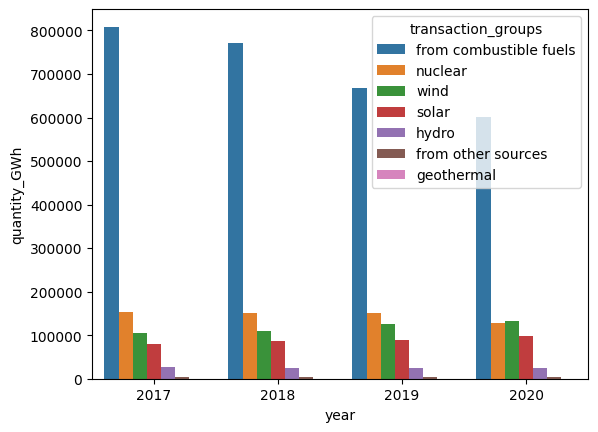

In [83]:
#create barplot
sns.barplot(data=production, x='year', y='quantity_GWh', hue='transaction_groups', hue_order=hue_order['transaction_groups'][:7]);

In [86]:
production['type'] = 'production'

/var/folders/4v/8q8s246j5t5_2qhs0c6ssd2m0000gn/T/ipykernel_71884/580361788.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  production['type'] = 'production'


In [87]:
production.head()

,year,transaction_groups,quantity_GWh,type
25,2017,from combustible fuels,808572.0,production
26,2017,from other sources,3402.0,production
27,2017,geothermal,326.0,production
30,2017,hydro,26155.0,production
34,2017,nuclear,152648.0,production


In [88]:
#production.to_csv('../data/cleaned/production.csv', index=False)

## Consumption values

In [90]:
data_shaped.transaction_groups.unique()

array(['consumption by chemical and petrochemical',
       'consumption by commercial and public services',
       'consumption by construction', 'consumption by food and tobacco',
       'consumption by households', 'consumption by iron and steel',
       'consumption by machinery',
       'consumption by manufacturing, construction and non-fuel industry',
       'consumption by mining and quarrying',
       'consumption by non-ferrous metals',
       'consumption by non-metallic minerals', 'consumption by other',
       'consumption by other manuf., const. and non-fuel ind.',
       'consumption by paper, pulp and print', 'consumption by rail',
       'consumption by road', 'consumption by textile and leather',
       'consumption by transport', 'consumption by transport equipment',
       'consumption by wood and wood products',
       'consumption in agriculture, forestry and fishing',
       'consumption not elsewhere specified (industry)',
       'energy industries own use', 'exp

In [93]:
consumption_values = ['consumption by chemical and petrochemical',
       'consumption by commercial and public services',
       'consumption by construction', 'consumption by food and tobacco',
       'consumption by households', 'consumption by iron and steel',
       'consumption by machinery',
       'consumption by manufacturing, construction and non-fuel industry',
       'consumption by mining and quarrying',
       'consumption by non-ferrous metals',
       'consumption by non-metallic minerals', 'consumption by other',
       'consumption by other manuf., const. and non-fuel ind.',
       'consumption by paper, pulp and print', 'consumption by rail',
       'consumption by road', 'consumption by textile and leather',
       'consumption by transport', 'consumption by transport equipment',
       'consumption by wood and wood products',
       'consumption in agriculture, forestry and fishing',
       'consumption not elsewhere specified (industry)',
       'energy industries own use',
        'own use by briquetting plants',
       'own use by coal mines', 'own use by coke ovens',
       'own use by electricity, heat and chp plants',
       'own use by oil and gas extraction', 'own use by oil refineries',
       'own use by pump-storage plants']

In [94]:
consumption = data_shaped[data_shaped['transaction_groups'].isin(consumption_values)]

In [95]:
consumption

,year,transaction_groups,quantity_GWh
0,2017,consumption by chemical and petrochemical,54219.0
1,2017,consumption by commercial and public services,141479.0
2,2017,consumption by construction,4136.0
3,2017,consumption by food and tobacco,18639.0
4,2017,consumption by households,128200.0
...,...,...,...
182,2020,own use by coke ovens,257.0
183,2020,"own use by electricity, heat and chp plants",27772.0
184,2020,own use by oil and gas extraction,501.0
185,2020,own use by oil refineries,5790.0


In [96]:
consumption['type']='consumption'

/var/folders/4v/8q8s246j5t5_2qhs0c6ssd2m0000gn/T/ipykernel_71884/4282722373.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consumption['type']='consumption'


## Merging production and consumption datasets

In [98]:
prod_consump = pd.concat([production,consumption], axis = 0, ignore_index=True)
prod_consump.head()

,year,transaction_groups,quantity_GWh,type
0,2017,from combustible fuels,808572.0,production
1,2017,from other sources,3402.0,production
2,2017,geothermal,326.0,production
3,2017,hydro,26155.0,production
4,2017,nuclear,152648.0,production


In [99]:
prod_consump.tail()

,year,transaction_groups,quantity_GWh,type
143,2020,own use by coke ovens,257.0,consumption
144,2020,"own use by electricity, heat and chp plants",27772.0,consumption
145,2020,own use by oil and gas extraction,501.0,consumption
146,2020,own use by oil refineries,5790.0,consumption
147,2020,own use by pump-storage plants,8872.0,consumption


In [101]:
prod_consump.to_csv('../data/cleaned/undata_for_analysis.csv', index=False)